In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

from scipy.stats import norm

import keras
from keras.datasets import mnist
from keras.layers import Input, Reshape, Conv2D, Conv2DTranspose, Flatten, Dense, Lambda
from keras.models import Model
from keras import metrics
from keras import backend as K   # 'generic' backend so code works with either tensorflow or theano

K.clear_session()
np.random.seed(237)

backend

keras is a model-level libarary, providing high-level building blocks for developing deep learning models. It does not handle low-level operations such as tensor products, convolutions and so on itself 

keras는 model-level 라이브러리, 딥러닝 모델 만들 때 블럭(레이어) 제공. 그래서 low level 관련 연산 핸들링 (variable 만들고, 연산) 못함 
대신, backend로 tensorflow, theano, CNTK  사용가능

In [16]:
import tensorflow._api.v2.compat.v1 as tf

tf.disable_v2_behavior() # tf1 &2간 함수 충돌 막기위해 적용 

In [17]:
# Load Dataset
(X_train, Y_train), (X_valid, Y_valid) = mnist.load_data()

In [18]:
# Normalize and reshape
X_train = X_train.astype('float32') / 255.
X_train = X_train.reshape(-1,28,28,1)

X_valid = X_valid.astype('float32') / 255.
X_valid = X_valid.reshape(-1,28,28,1)

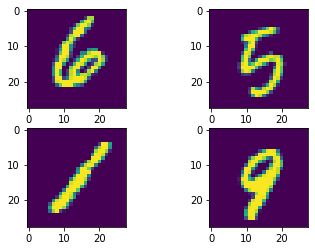

In [19]:
plt.figure(1)
plt.subplot(221)
plt.imshow(X_train[13][:,:,0])

plt.subplot(222)
plt.imshow(X_train[690][:,:,0])

plt.subplot(223)
plt.imshow(X_train[2375][:,:,0])

plt.subplot(224)
plt.imshow(X_train[42013][:,:,0])
plt.show()

In [20]:
img_shape = (28, 28, 1)    # for MNIST
batch_size = 16
latent_dim = 2  # Number of latent dimension parameters

# Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
input_img = Input(shape=img_shape)

x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
# need to know the shape of the network here for the decoder
shape_before_flattening = K.int_shape(x)

x = Flatten()(x)
x = Dense(32, activation='relu')(x)

# Two outputs, latent mean and (log)variance
z_mu = Dense(latent_dim)(x)
z_log_sigma = Dense(latent_dim)(x)

In [21]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = Lambda(sampling)([z_mu, z_log_sigma])

In [22]:
# decoder takes the latent distribution sample as input
decoder_input = Input(K.int_shape(z)[1:])

# Expand to 784 total pixels
x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)

# reshape
x = Reshape(shape_before_flattening[1:])(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
x = Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = Conv2D(1, 3, padding='same', activation='sigmoid')(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

In [23]:
# construct a custom layer to calculate the loss
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = metrics.binary_crossentropy(x, z_decoded)
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

In [24]:
# VAE model statement
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_6[0][0]                   
____________________________________________________________________________________________

In [25]:
num_epochs = 3

Instructions for updating:
non-resource variables are not supported in the long term


In [26]:
vae.fit(x=X_train, y=None, shuffle=True, 
epochs=num_epochs, batch_size=batch_size, validation_data=(X_valid, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - ETA: 0s - loss: 0.3175

/opt/anaconda3/envs/vaetf/lib/python3.6/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


60000/60000 [==============================] - 488s 8ms/sample - loss: 0.3175 - val_loss: 0.1947
Epoch 2/10
60000/60000 [==============================] - 506s 8ms/sample - loss: 0.1920 - val_loss: 0.1910
Epoch 3/10
60000/60000 [==============================] - 474s 8ms/sample - loss: 0.1879 - val_loss: 0.1879
Epoch 4/10
60000/60000 [==============================] - 473s 8ms/sample - loss: 0.1855 - val_loss: 0.1854
Epoch 5/10
60000/60000 [==============================] - 452s 8ms/sample - loss: 0.1838 - val_loss: 0.1843
Epoch 6/10
60000/60000 [==============================] - 496s 8ms/sample - loss: 0.1827 - val_loss: 0.1823
Epoch 7/10
60000/60000 [==============================] - 491s 8ms/sample - loss: 0.1817 - val_loss: 0.1814
Epoch 8/10
60000/60000 [==============================] - 505s 8ms/sample - loss: 0.1809 - val_loss: 0.1812
Epoch 9/10
60000/60000 [==============================] - 504s 8ms/sample - loss: 0.1803 - val_loss: 0.1806
Epoch 10/10
60000/60000 [==============

/opt/anaconda3/envs/vaetf/lib/python3.6/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


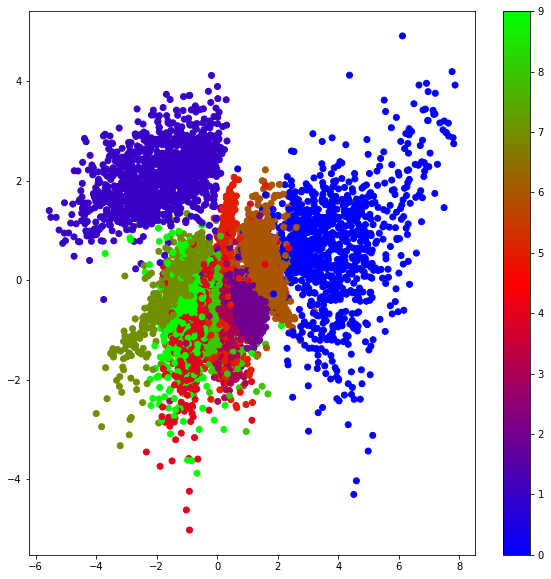

In [27]:
# Translate into the latent space
encoder = Model(input_img, z_mu)
X_valid_encoded = encoder.predict(X_valid, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(X_valid_encoded[:, 0], X_valid_encoded[:, 1], c=Y_valid, cmap='brg')
plt.colorbar()
plt.show()

/opt/anaconda3/envs/vaetf/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("brg"))
  This is separate from the ipykernel package so we can avoid doing imports until


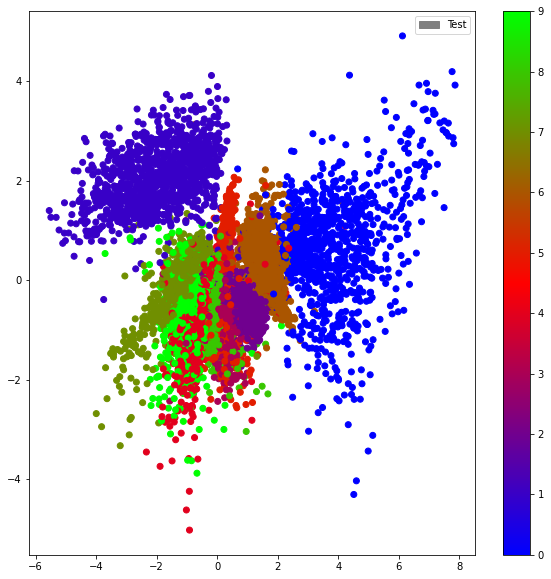

In [28]:
# set colormap so that 11's are gray
custom_cmap = matplotlib.cm.get_cmap('brg')
custom_cmap.set_over('gray')

X_valid_encoded = encoder.predict(X_valid, batch_size=batch_size)
plt.figure(figsize=(10, 10))
gray_marker = mpatches.Circle(4,radius=0.1,color='gray', label='Test')
plt.legend(handles=[gray_marker], loc = 'best')
plt.scatter(X_valid_encoded[:, 0], X_valid_encoded[:, 1], c=Y_valid, cmap=custom_cmap)
plt.clim(0, 9)
plt.colorbar()

/opt/anaconda3/envs/vaetf/lib/python3.6/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


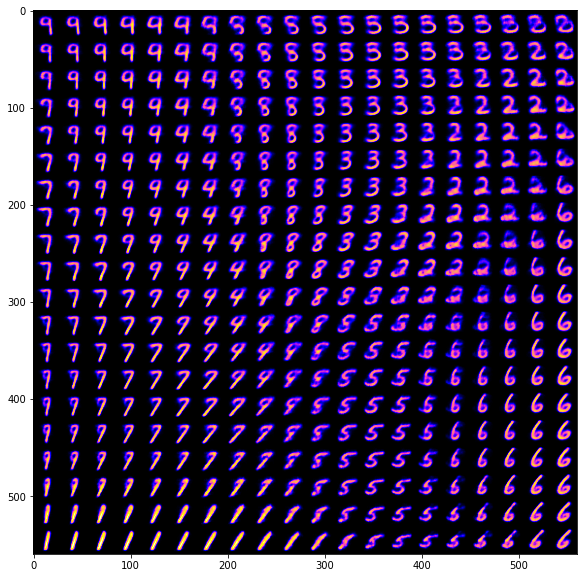

In [29]:
# Display a 2D manifold of the digits
n = 20  # figure with 20x20 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        Z_sample = np.array([[xi, yi]])
        Z_sample = np.tile(Z_sample, batch_size).reshape(batch_size, 2)
        X_decoded = decoder.predict(Z_sample, batch_size=batch_size)
        digit = X_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gnuplot2')
plt.show()  